# Experiment 1: GDPolyak on a Fourth order Rosenbrock Function

In this experiment, we illustrate GDPolyak algorithm on a Rosenbrock function:

$$f(x, y) = x^4 + (y - x^2)^2$$

We compare the performance of three algorithms: $\mathtt{GDPolyak}$, gradient descent with constant stepsize (GD), and gradient descent with Polyak stepsize (Polyak). For $\mathtt{GDPolyak}$, we run the method for 50 epochs, each consisting of 100 steps, using a constant stepsize of $.125$ within each epoch. The plots show that while GD and Polyak converge sublinearly, $\mathtt{GDPolyak}$ achieves linear convergence. Moreover, the stepsizes used by $\mathtt{GDPolyak}$ grow exponentially with the iteration count. 



Running $\mathtt{GDPolyak}$ with $K=100$ and $T=50$
Iteration 1000: loss = 5.7861221154602e-10
Iteration 1000: distance to opt sol = 0.004904524395248813


/var/folders/y5/4zrm18_56lzgk0gv8sz98s3w0000gn/T/ipykernel_99760/3582104727.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(initial_x, requires_grad=True)


Iteration 2000: loss = 5.7802385866687174e-15
Iteration 2000: distance to opt sol = 0.0002757315366887018
Iteration 3000: loss = 5.81281478229042e-20
Iteration 3000: distance to opt sol = 1.552732421304554e-05
Iteration 4000: loss = 5.845706241616509e-25
Iteration 4000: distance to opt sol = 8.743981837517187e-07
Iteration 5000: loss = 5.8787842633789175e-30
Iteration 5000: distance to opt sol = 4.924043497946851e-08

Running $\mathtt{{Polyak}}$
Iteration 1000: loss = 2.789366335196447e-11
Iteration 1000: distance to opt sol = 0.0019926103696344
Iteration 2000: loss = 3.1497208814324764e-11
Iteration 2000: distance to opt sol = 0.0012027126264761464
Iteration 3000: loss = 1.033555366664887e-12
Iteration 3000: distance to opt sol = 0.000982957647855667
Iteration 4000: loss = 5.358356532207563e-13
Iteration 4000: distance to opt sol = 0.0007099122311676437
Iteration 5000: loss = 1.9480194091949447e-13
Iteration 5000: distance to opt sol = 0.0006638961868918446

Running $\mathtt{{GD}}$
It

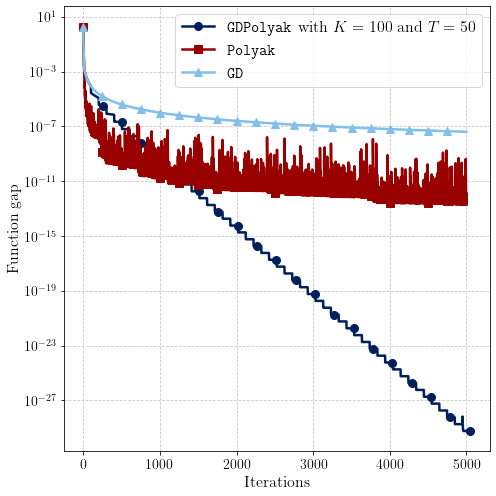

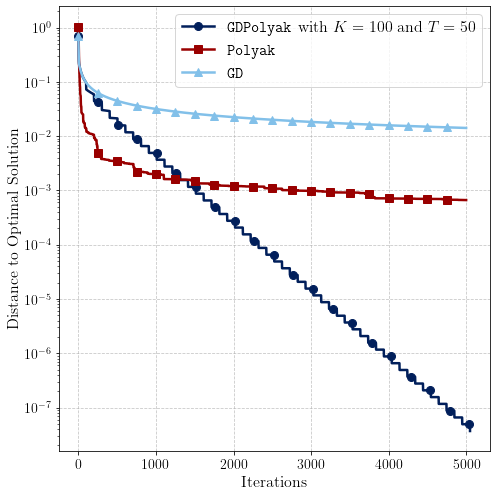

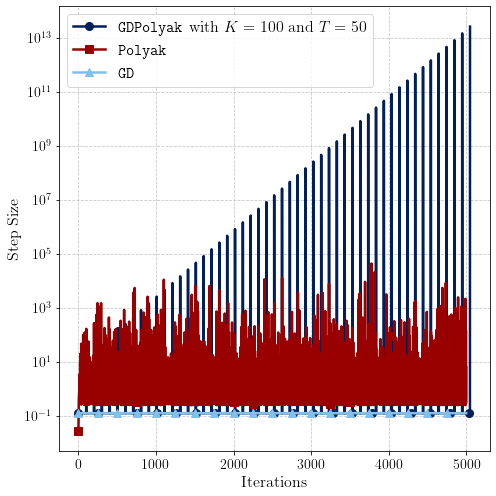

In [3]:
# %%
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import src.GDPolyak as GDPolyak
import torch.nn.functional as F
from src.utils import plot_gdpolyak_results
# Define the function of two variables 
# f(x,y) = x^4 + (y - x^2)^2 in pytorch
# for this we'll need to define a function that takes in a tensor of size 2 and returns a tensor of size 1
seed = 3407
torch.manual_seed(seed)
x = torch.randn(2, requires_grad=True, dtype=torch.double)
# save initial value of x 
initial_x = x.clone()
def loss_function():
    return x[0]**4 + (x[1] - x[0]**2)**2

opt_solution = torch.tensor([0.0, 0.0], requires_grad=True, dtype=torch.double)

# Define the distance function
def distance_to_opt():
    return torch.norm(x - opt_solution).item()

# Setting up the experiment
K = 100
T = 50

GD_step_size = 0.125
nb_restarts = 1
cases = [
    {
        "name": f"$\mathtt{{GDPolyak}}$ with $K={K}$ and $T={T}$",
        "nb_GD_steps": K,
        "nb_polyak_steps": T,
        "nb_restarts": nb_restarts,
        "GD_step_size": GD_step_size
    },
    {
        "name": "$\mathtt{{Polyak}}$",
        "nb_GD_steps": 0,
        "nb_polyak_steps": K*T,
        "nb_restarts": nb_restarts,
        "GD_step_size": GD_step_size
    },
    {
        "name": "$\mathtt{{GD}}$",
        "nb_GD_steps": K*T,
        "nb_polyak_steps": 0,
        "nb_restarts": 1,
        "GD_step_size": GD_step_size
    }
]

# Run each case and store results
results = []
for case in cases:
    print(f"\nRunning {case['name']}")
    x = torch.tensor(initial_x, requires_grad=True)
    
    result = GDPolyak.run_gdpolyak_algorithm(
        loss_function,
        [x],
        nb_restarts=case['nb_restarts'],
        nb_polyak_steps=case['nb_polyak_steps'],
        nb_gd_steps=case['nb_GD_steps'],
        gd_step_size=case['GD_step_size'],
        opt_est=0,
        distance_func=distance_to_opt,
        print_freq=1000
    )
    
    results.append({
        "name": case['name'],
        "history_loss": result['loss'],
        "history_dist_to_opt_solution": result['dist_to_opt'],
        "step_size_list": result['step_sizes']
    })


plot_gdpolyak_results(results, save_path='./figures/rosenbrock', experiment_name='Rosenbrock')



# Experiment 2: Overparameterized Quadratic Sensing Experiment

In this experiment, we demonstrate the performance of the GDPolyak algorithm on an overparameterized quadratic sensing problem. The task is to recover a low-rank matrix from quadratic measurements, which has applications in various fields such as quantum state tomography, image processing, multi-task regression, and metric embeddings.

In the experiment, we aim to recover a symmetric positive semi-definite matrix $X \in \mathbb{R}^{d\times d}$ with low rank $r \ll d$ from a set of linear measurements $y_i = \langle A_i, X \rangle$, where $A_i \in \mathbb{R}^{d\times d}$ are known matrices. We use a low-rank factorization approach, representing $X = BB^\top$ and optimizing the mean-square-error over the factors:

$$
\min_{B \in \mathbb{R}^{d\times k}} f(B) = \frac{1}{4m} \sum_{i=1}^m (y_i - \langle A_i, BB^\top \rangle)^2
$$

Below, we set the true rank $r = 2$ and the overparameterized rank $k = 4$. The matrix dimension $d = 100$ and the number of measurements $m = 1000$.In addition, each measurement matrix $A_i$ is of the form $A_i = a_i a_i^\top - \tilde{a}_i \tilde{a}_i^\top$, where $a_i$ and $\tilde{a}_i$ are $d$-dimensional standard Gaussian vectors.

We compare the performance of three algorithms: $\mathtt{GDPolyak}$, gradient descent with constant stepsize (GD), and gradient descent with Polyak stepsize (Polyak). For $\mathtt{GDPolyak}$, we run the method for 50 epochs, each consisting of 300 steps, using a constant stepsize of $.05$ within each epoch. The plots show that while GD and Polyak converge sublinearly, $\mathtt{GDPolyak}$ achieves linear convergence. Moreover, the stepsizes used by $\mathtt{GDPolyak}$ grow exponentially with the iteration counter. 





Running $\mathtt{GDPolyak}$ with $K=300$ and $T=50$
Iteration 5000: loss = 6.2816518424516314e-12
Iteration 5000: distance to opt sol = 0.00213714597475242
Iteration 10000: loss = 2.0806698592660778e-16
Iteration 10000: distance to opt sol = 0.0001644606593153577
Iteration 15000: loss = 3.303866528557604e-20
Iteration 15000: distance to opt sol = 1.8763598971976428e-05

Running $\mathtt{{Polyak}}$
Iteration 5000: loss = 9.326082114261944e-11
Iteration 5000: distance to opt sol = 0.00430403695823131
Iteration 10000: loss = 1.8714096013680845e-11
Iteration 10000: distance to opt sol = 0.002708310793262059
Iteration 15000: loss = 8.684186954026881e-12
Iteration 15000: distance to opt sol = 0.0019321294982550007

Running $\mathtt{{GD}}$
Iteration 5000: loss = 6.14520490950798e-07
Iteration 5000: distance to opt sol = 0.03683494390737772
Iteration 10000: loss = 1.6611048283028522e-07
Iteration 10000: distance to opt sol = 0.026833140366952606
Iteration 15000: loss = 7.674132988474075e-08
I

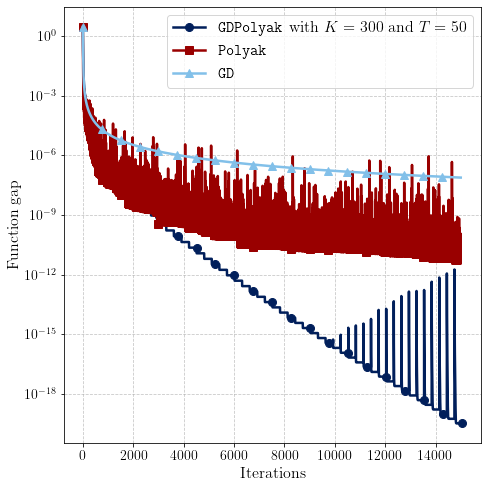

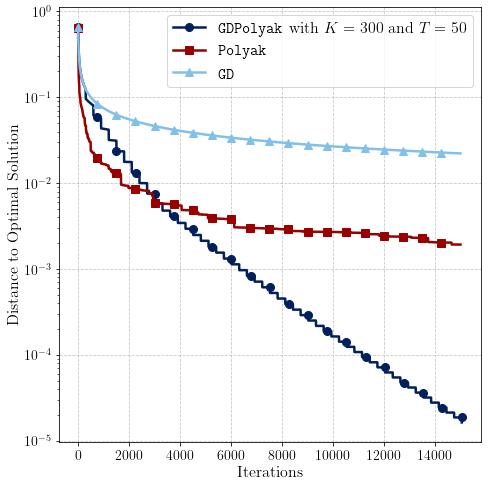

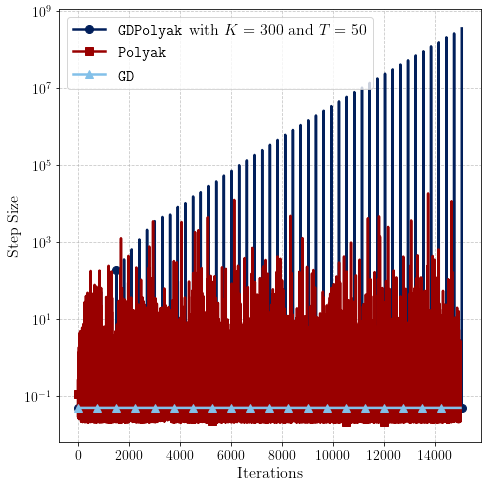

In [5]:
# Import necessary functions and modules
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.GDPolyak as GDPolyak
from src.utils import plot_gdpolyak_results

# Define the quadratic_sensing problem parameters
rank_solution = 2
rank_factorization = 4
dimension = 100
nb_measurements = 1000
seed = 3407

# Generate the problem instance
torch.manual_seed(seed)
ground_truth = torch.randn(dimension, rank_solution, dtype=torch.double)
ground_truth = ground_truth / ground_truth.norm()
# Pad the ground truth with zeros on the right
padded_ground_truth = torch.zeros(dimension, rank_factorization, dtype=torch.double)
padded_ground_truth[:, :rank_solution] = ground_truth
ground_truth = padded_ground_truth

x = torch.randn(rank_factorization * dimension, dtype=torch.double)
x = x / torch.norm(x)
x.requires_grad = True

A = torch.randn(nb_measurements, dimension, dtype=torch.double)
B = torch.randn(nb_measurements, dimension, dtype=torch.double)
y = torch.sum((A @ ground_truth)**2, dim=1) - torch.sum((B @ ground_truth)**2, dim=1)

def loss_function():
    x_matrix = x.view(dimension, rank_factorization)
    return F.mse_loss(torch.sum((A @ x_matrix)**2, dim=1) - torch.sum((B @ x_matrix)**2, dim=1), y)

# Define the procrustes distance function
def procrustes_distance():
    x_matrix = x.view(dimension, rank_factorization)
    U1, _, V1 = torch.svd(x_matrix)
    U2, _, V2 = torch.svd(ground_truth)
    R = U1 @ U2.t()
    R2 = V2 @ V1.t()
    return torch.norm(x_matrix  - R @ ground_truth @ R2, 'fro')

# Set up the optimization parameters for three cases
K = 300
T = 50
GD_step_size = 0.05
cases = [
    {
        "name": f"$\mathtt{{GDPolyak}}$ with $K={K}$ and $T={T}$",
        "nb_GD_steps": K,
        "nb_polyak_steps": T,
        "nb_restarts": 1,
        "GD_step_size": GD_step_size
    },
    {
        "name": "$\mathtt{{Polyak}}$",
        "nb_GD_steps": 0,
        "nb_polyak_steps": K*T,
        "nb_restarts": 1,
        "GD_step_size": GD_step_size
    },
    {
        "name": "$\mathtt{{GD}}$",
        "nb_GD_steps": K*T,
        "nb_polyak_steps": 0,
        "nb_restarts": 1,
        "GD_step_size": GD_step_size
    }
]

opt_est = 0  # The optimal value is 0 for this problem
results = []

# Clone the initial x so all algorithms are initialized at the same point
initial_x = x.clone().detach().requires_grad_(True)

# Run the GDPolyak algorithm for each case
for case in cases:
    print(f"\nRunning {case['name']}")
    # Create a new clone of initial_x for each case
    x = initial_x.clone().detach().requires_grad_(True)
    
    result = GDPolyak.run_gdpolyak_algorithm(
        loss_function,
        [x],
        nb_restarts=case['nb_restarts'],
        nb_polyak_steps=case['nb_polyak_steps'],
        nb_gd_steps=case['nb_GD_steps'],
        gd_step_size=case['GD_step_size'],
        opt_est=opt_est,
        print_freq=5000,
        distance_func=procrustes_distance
    )
    results.append({
        'name': case['name'],
        'history_loss': result['loss'],
        'step_size_list': result['step_sizes'],
        'history_dist_to_opt_solution': result['dist_to_opt']
    })

plot_gdpolyak_results(results, save_path='./figures/quadratic_sensing', experiment_name='Quadratic Sensing')



# Experiment 3: Learning a Single Neuron in the Overparameterized Regime

In this experiment, we consider the problem of learning a single neuron in the overparameterized regime, as studied by Xu and Du (2023). The objective function for this problem is:

$$
\min_{w}~ f(w) = \mathbb{E}_{x\sim N(0,I)}\left[ \frac{1}{2}\left(\sum_{i=1}^{n}[w_i^\top x]_+ - [v^\top x]_+ \right)^2\right],
$$

where $w = (w_1^\top, w_2^\top,\ldots, w_n^\top)^\top \in \mathbb{R}^{n\times d}$ denotes the parameter vector.

In our experiment, we focus on the simplest overparameterized setting with $n=2$ and $d=100$. Interestingly, the population objective for this problem has an explicit form, which is implemented in the `loss_function()` defined in the code below. This explicit form allows us to directly optimize the population loss without sampling.

We compare the performance of three algorithms: $\mathtt{GDPolyak}$, gradient descent with constant stepsize (GD), and gradient descent with Polyak stepsize (Polyak). For $\mathtt{GDPolyak}$, we run the method for 25 epochs, each consisting of 100 steps, using a constant stepsize of $1.5$ within each epoch. The plots show that while GD and Polyak converge sublinearly, $\mathtt{GDPolyak}$ achieves linear convergence. Moreover, the stepsizes used by $\mathtt{GDPolyak}$ grow exponentially with the iteration counter. 




Running $\mathtt{GDPolyak}$ with $K=100$ and $T=25$
Iteration 1000: loss = 4.1580301237578324e-11
Iteration 1000: distance to opt sol = 2.149458403009337e-06
Iteration 2000: loss = 4.4072091179672044e-18
Iteration 2000: distance to opt sol = 3.908821192500544e-11
NaN loss value encountered. Stopping GDPolyak.
NaN loss value encountered. Stopping GDPolyak.

Running $\mathtt{{Polyak}}$
Iteration 1000: loss = 2.256909907262232e-12
Iteration 1000: distance to opt sol = 2.675517909342877e-06
Iteration 2000: loss = 1.4597285138916051e-13
Iteration 2000: distance to opt sol = 1.732876087405989e-07

Running $\mathtt{{GD}}$
Iteration 1000: loss = 5.814673512597118e-08
Iteration 1000: distance to opt sol = 0.00027253057585895253
Iteration 2000: loss = 7.327099191598573e-09
Iteration 2000: distance to opt sol = 6.856983256543268e-05


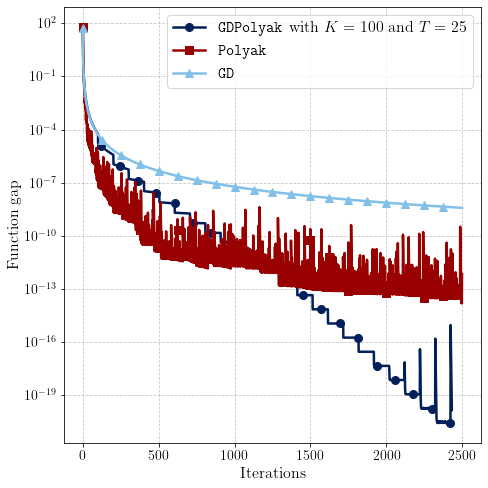

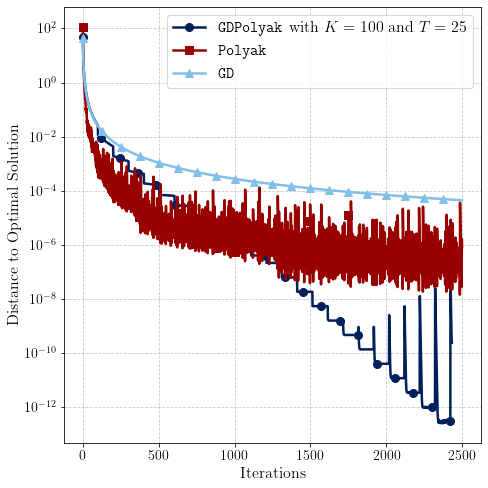

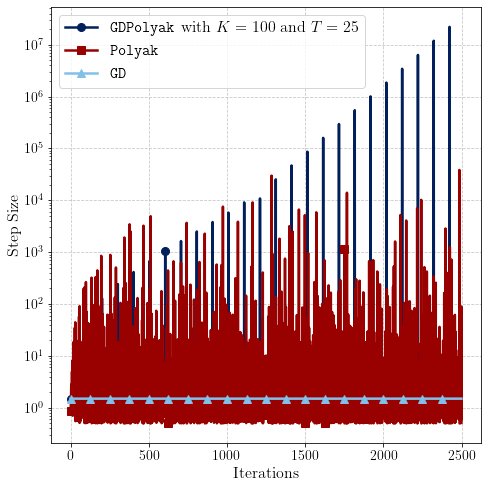

In [2]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import src.GDPolyak as GDPolyak
import torch.nn.functional as F
from src.utils import plot_gdpolyak_results

# Set the seed for reproducibility
seed = 3407
torch.manual_seed(seed)

# Define the dimension d and create random vectors w1, w2, and v
d = 100  # example dimension, modify as needed
w1 = torch.randn(d, requires_grad=True, dtype=torch.double)
w2 = torch.randn(d, requires_grad=True, dtype=torch.double)
v = torch.randn(d, requires_grad=False, dtype=torch.double)


# Function to compute the loss function f(w) without using zip
def loss_function():
    # Compute norms
    norm_w1 = torch.norm(w1)
    norm_w2 = torch.norm(w2)
    norm_v = torch.norm(v)
    
    # Compute cosine values using dot products
    cos_theta12 = torch.dot(w1, w2) / (norm_w1 * norm_w2)  # cos(theta_12)
    cos_theta1 = torch.dot(w1, v) / (norm_w1 * norm_v)     # cos(theta_1)
    cos_theta2 = torch.dot(w2, v) / (norm_w2 * norm_v)     # cos(theta_2)

    # Use trigonometric identity: sin(theta) = sqrt(1 - cos^2(theta))
    sin_theta12 = torch.sqrt(1 - cos_theta12 ** 2)
    sin_theta1 = torch.sqrt(1 - cos_theta1 ** 2)
    sin_theta2 = torch.sqrt(1 - cos_theta2 ** 2)
    
    # First term of the loss: 1/4 * ||w1 + w2 - v||^2
    term1 = (1/4) * torch.norm(w1 + w2 - v) ** 2

    # Second term: (1/2pi) * (sin(theta12) - theta12 * cos(theta12)) * ||w1|| * ||w2||
    term2 = (1 / (2 * np.pi)) * ((sin_theta12 - torch.acos(cos_theta12) * cos_theta12) * norm_w1 * norm_w2)

    # Third term for w1: (sin(theta1) - theta1 * cos(theta1)) * ||w1|| * ||v||
    term3_w1 = (sin_theta1 - torch.acos(cos_theta1) * cos_theta1) * norm_w1 * norm_v

    # Third term for w2: (sin(theta2) - theta2 * cos(theta2)) * ||w2|| * ||v||
    term3_w2 = (sin_theta2 - torch.acos(cos_theta2) * cos_theta2) * norm_w2 * norm_v

    # Loss function
    return term1 + term2 - (1 / (2 * np.pi)) * (term3_w1 + term3_w2)



# Function to compute distance to optimal solution with no gradient tracking
# Function to compute the distance to the solution
@torch.no_grad()
def distance_to_opt():
# Compute the norm difference ||w1 + w2 - v||
    norm_diff = torch.norm(w1 + w2 - v)
    norm_v = torch.norm(v)
    norm_w1 = torch.norm(w1)
    norm_w2 = torch.norm(w2)
    # Compute the absolute difference |dot(wi, v) - norm(wi)*norm(v)|
    abs_diff_w1 = torch.abs(torch.dot(w1, v) - norm_w1 * norm_v)
    abs_diff_w2 = torch.abs(torch.dot(w2, v) - norm_w2 * norm_v)

    # Compute the max{||w_i|| - 2||v||, 0} terms
    max_norm_diff_w1 = torch.max(torch.tensor([0.0], dtype=torch.double), norm_w1 - 2 * norm_v)
    max_norm_diff_w2 = torch.max(torch.tensor([0.0], dtype=torch.double), norm_w2 - 2 * norm_v)

    # Compute the max{||v|| / 8 - ||w_i||, 0} terms
    max_norm_fraction_w1 = torch.max(torch.tensor([0.0], dtype=torch.double), norm_v / 8 - norm_w1)
    max_norm_fraction_w2 = torch.max(torch.tensor([0.0], dtype=torch.double), norm_v / 8 - norm_w2)

      
    total_distance = (norm_diff +
                    abs_diff_w1 + abs_diff_w2 +
                    max_norm_diff_w1 + max_norm_diff_w2 +
                    max_norm_fraction_w1 + max_norm_fraction_w2)

    return total_distance.item()





# Parameters for the experiment
K = 100
T = 25
GD_step_size = 1.5
nb_restarts = 1

# Define the cases for different optimization algorithms
cases = [
    {
        "name": f"$\mathtt{{GDPolyak}}$ with $K={K}$ and $T={T}$",
        "nb_GD_steps": K,
        "nb_polyak_steps": T,
        "nb_restarts": nb_restarts,
        "GD_step_size": GD_step_size
    },
    {
        "name": "$\mathtt{{Polyak}}$",
        "nb_GD_steps": 0,
        "nb_polyak_steps": K * T,
        "nb_restarts": nb_restarts,
        "GD_step_size": GD_step_size
    },
    {
        "name": "$\mathtt{{GD}}$",
        "nb_GD_steps": K * T,
        "nb_polyak_steps": 0,
        "nb_restarts": 1,
        "GD_step_size": GD_step_size
    }
]

# Run each case and store results
results = []
for case in cases:
    print(f"\nRunning {case['name']}")
    
    # Reset w1 and w2 for each run
    w1 = torch.randn(d, requires_grad=True, dtype=torch.double)
    w2 = torch.randn(d, requires_grad=True, dtype=torch.double)
    
    result = GDPolyak.run_gdpolyak_algorithm(
        loss_function,
        [w1, w2],
        nb_restarts=case['nb_restarts'],
        nb_polyak_steps=case['nb_polyak_steps'],
        nb_gd_steps=case['nb_GD_steps'],
        gd_step_size=case['GD_step_size'],
        opt_est=0,
        distance_func=distance_to_opt,
        print_freq=1000
    )
    
    results.append({
        "name": case['name'],
        "history_loss": result['loss'],
        "history_dist_to_opt_solution": result['dist_to_opt'],
        "step_size_list": result['step_sizes']
    })

# Plot the results
plot_gdpolyak_results(results, save_path='./figures/neural_network', experiment_name='Neural Network')
